<a href="https://colab.research.google.com/github/ChecinskiBartlomiej/UM/blob/main/UM_hw_09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework Assignment - *Do Androids Dream of Electric Sheep?***

-------------------------------------  

"Do Androids Dream of Electric Sheep?" – the famous title of Philip K. Dick’s novel – raises a fascinating question: if artificial intelligence could dream, what would it see?  

In this assignment, we explore a phenomenon known as **neural network dreams**, where instead of optimizing a neural network's weights, we **optimize the input itself** to achieve a desired classification outcome. Given a fully trained MNIST classification network, your goal is to manipulate its inputs so that it confidently predicts each digit from 0 to 9, starting from pure noise.  

## **Tasks Description**  

During this class we designed and trained a **MNIST classification neural network**, which takes a **batch of grayscale images** of size **$28 \times 28$** as input and outputs a probability distribution over the 10 digit classes (0–9). However, instead of using real MNIST images, you will **treat the input batch itself as a set of trainable parameters** and optimize it so that the network classifies each image as a specific digit.  

1. Your first task is to generate **a batch of 10 images**, where each image is
   classified as one of the digits **0, 1, 2, ..., 9**, starting from an initial batch of ten random Gaussian noise images.  

   Discuss the following question: do the generated images resemble real MNIST digits? Why or why not?  

2. Discuss, how you would approach a second task of
   generating an image that   
   bares similarity to two or more digits simultaneously. **Implement your idea to see the results.**

3. Third task: repeat the previous tasks with an additional L2 penalty on noise within the images. Experiment with adding `lambda_l2 * dreamed_input_batch.pow(2).mean()` loss term, with `lambda_l2` being the penalty cooefficient within an exponential progression, say from 0.001 to 10.0. Are the new digits recognized correctly? How does the penalty impact the digit quality? Explain.

### **Optimization Process for Task 1**  

1. Start with a **batch of 10 random Gaussian noise images** as the initial input and $(0, 1, 2, \ldots, 9)$ as the expected output batch of target digits.  
2. Define the objective: maximize the neural network's confidence for the corresponding target digit for each image in the batch.  
3. Use **gradient descent** to modify the pixels in each image, making the network classify each one as the assigned digit.  
4. Repeat until the network assigns suffieciently high confidence to each image’s target class.  

### **Implementation Details**  

- The neural network weights **must remain frozen** during optimization. You are modifying only the input images.  
- The loss function should be the **cross-entropy loss** between the predicted probabilities and the desired class labels (plus an optional weighted L2 penalty regularizing the images in task 3).


## **Points to Note**  

1. **Visualize** the optimization process: Save images of the generated inputs at different steps and plot the classification confidence evolution over iterations.  
3. **Document your findings** and explain the behavior you observe.  

## **Task & Deliverables**  

- A **Colab notebook** containing solutions for both tasks:
  - The full implementation.
  - Visualizations of the generated batch of images.
  - A written explanation of your observations.
- **Bonus:** If you create an **animation** showing the evolution of the input images during optimization, it will be considered a strong enhancement to your submission.
  - You can generate an animation programmatically (e.g., using Matplotlib or OpenCV).
  - Or, save image frames and use external tools to create a video.
  - Provide a **link** to any video files in the README.
- Upload your notebook and results to your **GitHub repository** for the course.
- In the **README**, include a **link** to the notebook.
- In the notebook, include **“Open in Colab”** badge so it can be launched directly.




In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt

# Train digit recognizer.

transform = torchvision.transforms.Compose(
    [ torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize((0.1307), (0.3081))])

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=2048,
                                          shuffle=True)

testset = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=1,
                                         shuffle=False)


class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = torch.nn.ReLU()
        self.flatten = torch.nn.Flatten()
        self.linear1 = torch.nn.Linear(1*28*28, 1024)
        self.linear2 = torch.nn.Linear(1024, 2048)
        self.linear3 = torch.nn.Linear(2048, 256)
        self.linear4 = torch.nn.Linear(256,10)
        self.dropout = torch.nn.Dropout(0.05)

    def forward(self, x):      # B, 1, 28, 28
        x = self.flatten(x)    # B, 784
        x = self.linear1(x)    # B, 1024
        x = self.relu(x)       # B, 1024
        x = self.linear2(x)    # B, 2048
        x = self.relu(x)       # B, 2048
        x = self.linear3(x)    # B, 256
        x = self.relu(x)       # B, 256
        x = self.linear4(x)    # B, 10
        x = self.dropout(x)
        return x


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")

net = MLP().to(device)
optimizer1 = torch.optim.Adam(net.parameters(), 0.001)

net.train()
for epoch in range(8):

    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        batch_inputs = batch_inputs.to(device)
        batch_labels = batch_labels.to(device)

        optimizer1.zero_grad()

        batch_outputs = net(batch_inputs)
        loss1 = torch.nn.functional.cross_entropy(batch_outputs, batch_labels, reduction = "mean")
        print("epoch:", epoch, "batch:", batch, "current batch loss:", loss1.item())
        loss1.backward()
        optimizer1.step()

100%|██████████| 9.91M/9.91M [00:00<00:00, 11.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 339kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.18MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.96MB/s]


Working on cuda
epoch: 0 batch: 0 current batch loss: 2.308471202850342
epoch: 0 batch: 1 current batch loss: 2.0770585536956787
epoch: 0 batch: 2 current batch loss: 1.604274868965149
epoch: 0 batch: 3 current batch loss: 1.1269159317016602
epoch: 0 batch: 4 current batch loss: 1.0362075567245483
epoch: 0 batch: 5 current batch loss: 1.1385376453399658
epoch: 0 batch: 6 current batch loss: 1.1080152988433838
epoch: 0 batch: 7 current batch loss: 0.9045559167861938
epoch: 0 batch: 8 current batch loss: 0.8059351444244385
epoch: 0 batch: 9 current batch loss: 0.6293308734893799
epoch: 0 batch: 10 current batch loss: 0.6272165775299072
epoch: 0 batch: 11 current batch loss: 0.6863446831703186
epoch: 0 batch: 12 current batch loss: 0.642625093460083
epoch: 0 batch: 13 current batch loss: 0.5171371698379517
epoch: 0 batch: 14 current batch loss: 0.5463225245475769
epoch: 0 batch: 15 current batch loss: 0.5041396021842957
epoch: 0 batch: 16 current batch loss: 0.521560788154602
epoch: 0 bat

Training with lambda = 0
epoch: 0 current loss: 22.5805721282959
epoch: 1000 current loss: 0.001458231476135552
epoch: 2000 current loss: 0.00042605510680004954
epoch: 3000 current loss: 0.00018700497457757592
epoch: 4000 current loss: 9.602912905393168e-05
epoch: 5000 current loss: 5.330859130481258e-05
epoch: 6000 current loss: 3.0660037737106904e-05
epoch: 7000 current loss: 1.8083843315253034e-05
epoch: 8000 current loss: 1.084797168005025e-05
epoch: 9000 current loss: 6.544562893395778e-06
epoch: 10000 current loss: 3.969659246649826e-06
epoch: 11000 current loss: 2.4080241018964443e-06
epoch: 12000 current loss: 1.4781937807128998e-06
epoch: 13000 current loss: 9.179109952128783e-07
epoch: 14000 current loss: 5.36441632448259e-07
epoch: 15000 current loss: 3.218650306280324e-07
epoch: 16000 current loss: 1.7881390590446244e-07
epoch: 17000 current loss: 1.1920927533992653e-07
epoch: 18000 current loss: 7.152556946721234e-08
epoch: 19000 current loss: 1.192092824453539e-08
epoch: 

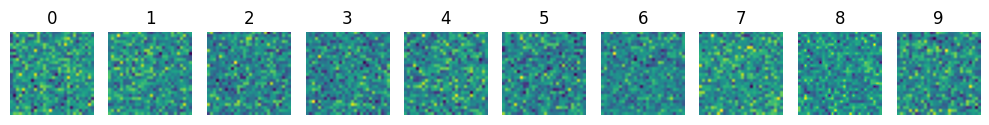

Finished training with lambda = 0
Training with lambda = 0.001
epoch: 0 current loss: 14.57021427154541
epoch: 1000 current loss: 0.0019147949060425162
epoch: 2000 current loss: 0.001189640024676919
epoch: 3000 current loss: 0.001020160038024187
epoch: 4000 current loss: 0.0009553770069032907
epoch: 5000 current loss: 0.0009240791550837457
epoch: 6000 current loss: 0.0009060804732143879
epoch: 7000 current loss: 0.0008937206002883613
epoch: 8000 current loss: 0.0008828122518025339
epoch: 9000 current loss: 0.0008703678031452
epoch: 10000 current loss: 0.0008535846136510372
epoch: 11000 current loss: 0.0008293428691104054
epoch: 12000 current loss: 0.0007940682698972523
epoch: 13000 current loss: 0.0007440916378982365
epoch: 14000 current loss: 0.0006763639394193888
epoch: 15000 current loss: 0.0005896245129406452
epoch: 16000 current loss: 0.00048585113836452365
epoch: 17000 current loss: 0.0003717013751156628
epoch: 18000 current loss: 0.00025851940154097974
epoch: 19000 current loss:

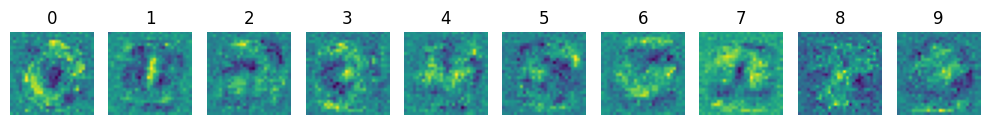

Finished training with lambda = 0.001
Training with lambda = 0.01
epoch: 0 current loss: 15.885190963745117
epoch: 1000 current loss: 0.010252120904624462
epoch: 2000 current loss: 0.009296908974647522
epoch: 3000 current loss: 0.009031254798173904
epoch: 4000 current loss: 0.008858938701450825
epoch: 5000 current loss: 0.0086715342476964
epoch: 6000 current loss: 0.008423794992268085
epoch: 7000 current loss: 0.008078032173216343
epoch: 8000 current loss: 0.007597506977617741
epoch: 9000 current loss: 0.0069506727159023285
epoch: 10000 current loss: 0.006123359780758619
epoch: 11000 current loss: 0.005134972743690014
epoch: 12000 current loss: 0.004043192602694035
epoch: 13000 current loss: 0.0029411211144179106
epoch: 14000 current loss: 0.0019409751985222101
epoch: 15000 current loss: 0.001138318213634193
epoch: 16000 current loss: 0.0005825170665048063
epoch: 17000 current loss: 0.00025962042855098844
epoch: 18000 current loss: 0.00010734423267422244
epoch: 19000 current loss: 5.12

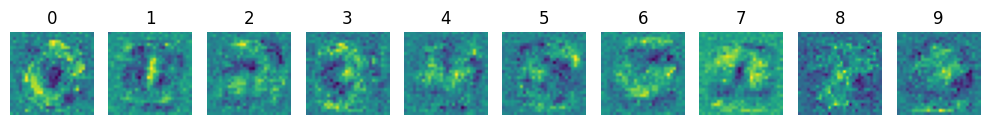

Finished training with lambda = 0.01
Training with lambda = 0.1
epoch: 0 current loss: 19.94725227355957
epoch: 1000 current loss: 0.09852642565965652
epoch: 2000 current loss: 0.09490902721881866
epoch: 3000 current loss: 0.09043458104133606
epoch: 4000 current loss: 0.08424435555934906
epoch: 5000 current loss: 0.07602305710315704
epoch: 6000 current loss: 0.06573174893856049
epoch: 7000 current loss: 0.05372463911771774
epoch: 8000 current loss: 0.04086185246706009
epoch: 9000 current loss: 0.028407704085111618
epoch: 10000 current loss: 0.01766406185925007
epoch: 11000 current loss: 0.009582554921507835
epoch: 12000 current loss: 0.004430246539413929
epoch: 13000 current loss: 0.0017429667059332132
epoch: 14000 current loss: 0.0006513360422104597
epoch: 15000 current loss: 0.0003274695191066712
epoch: 16000 current loss: 0.00026566197630017996
epoch: 17000 current loss: 0.0002593234530650079
epoch: 18000 current loss: 0.00025902100605890155
epoch: 19000 current loss: 0.000259006075

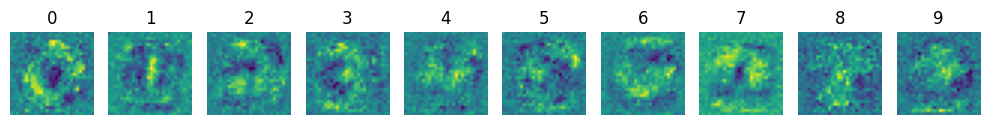

Finished training with lambda = 0.1
Training with lambda = 1.0
epoch: 0 current loss: 23.155683517456055
epoch: 1000 current loss: 0.8369503021240234
epoch: 2000 current loss: 0.6777797341346741
epoch: 3000 current loss: 0.5155344009399414
epoch: 4000 current loss: 0.3630417585372925
epoch: 5000 current loss: 0.2316104918718338
epoch: 6000 current loss: 0.13017715513706207
epoch: 7000 current loss: 0.06244173273444176
epoch: 8000 current loss: 0.02489236555993557
epoch: 9000 current loss: 0.008499417454004288
epoch: 10000 current loss: 0.0032407196704298258
epoch: 11000 current loss: 0.0021247414406389
epoch: 12000 current loss: 0.001992336008697748
epoch: 13000 current loss: 0.0019850421231240034
epoch: 14000 current loss: 0.0019849753007292747
epoch: 15000 current loss: 0.0019849720411002636
epoch: 16000 current loss: 0.0019850078970193863
epoch: 17000 current loss: 0.0019851422403007746
epoch: 18000 current loss: 0.0019852453842759132
epoch: 19000 current loss: 0.00198532547801733
e

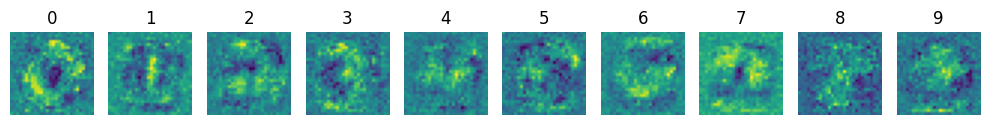

Finished training with lambda = 1.0
Training with lambda = 10.0
epoch: 0 current loss: 30.5116024017334
epoch: 1000 current loss: 5.777950286865234
epoch: 2000 current loss: 2.5175797939300537
epoch: 3000 current loss: 0.9083269834518433
epoch: 4000 current loss: 0.26454606652259827
epoch: 5000 current loss: 0.06438101083040237
epoch: 6000 current loss: 0.020885122939944267
epoch: 7000 current loss: 0.01531143207103014
epoch: 8000 current loss: 0.014991880394518375
epoch: 9000 current loss: 0.014986303634941578
epoch: 10000 current loss: 0.014986698515713215
epoch: 11000 current loss: 0.01498684473335743
epoch: 12000 current loss: 0.014987636357545853
epoch: 13000 current loss: 0.014988534152507782
epoch: 14000 current loss: 0.014986992813646793
epoch: 15000 current loss: 0.014987781643867493
epoch: 16000 current loss: 0.014988426119089127
epoch: 17000 current loss: 0.014987497590482235
epoch: 18000 current loss: 0.01498816255480051
epoch: 19000 current loss: 0.01498810201883316
epoch:

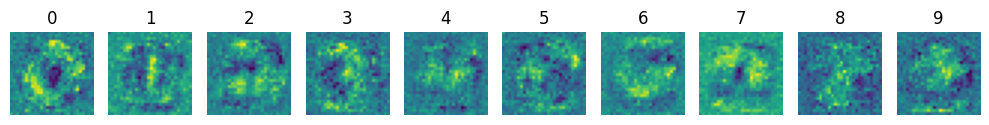

Finished training with lambda = 10.0


In [9]:
# Function for optimizing inputs of digit recognizer.
def train(l, epochs):
    samples = torch.randn(10, 1, 28, 28, device=device, requires_grad=True)
    # Normalize samples.
    mean = torch.tensor(0.1307, device=device).reshape(1,1,1,1)
    std  = torch.tensor(0.3081, device=device).reshape(1,1,1,1)

    labels = torch.arange(10, device=device)
    optimizer2 = torch.optim.Adam([samples], 0.001)
    net.eval()
    for epoch in range(epochs):
        optimizer2.zero_grad()
        normed = (samples - mean) / std
        logits = net(normed)
        loss2 = torch.nn.functional.cross_entropy(logits, labels, reduction="mean") + l * samples.pow(2).mean()
        if epoch % 1000 == 0:
            print("epoch:", epoch, "current loss:", loss2.item())
        loss2.backward()
        optimizer2.step()
    return samples

# Function for plotting inputs of digit recognizer.
def plot_images(images):
    fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(10, 10))
    for i, ax in enumerate(axes):
        img = images[i].squeeze().cpu().detach()
        ax.imshow(img)
        ax.set_title(f"{i}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()


epochs = 30000

# Train and plot for different lambdas.
lambda_values = [0, 0.001, 0.01, 0.1, 1.0, 10.0]
for l in lambda_values:
    print(f"Training with lambda = {l}")
    images = train(l, epochs)
    plot_images(images)
    print(f"Finished training with lambda = {l}")





When $\lambda=0$, the generated images do not resemble real digits. However, for $\lambda>0$, the generated images exhibit certain characteristics of real digits, but they still retain noticeable differences, making it possible to distinguish them from actual handwritten digits.

For the second task, to generate an image that resembles two or more digits, we can modify the loss function. Specifically, instead of minimizing the cross-entropy loss between the neural network's output and a single digit, we minimize the sum of two such terms, corresponding to the multiple digits. Additionally, we can introduce a penalty term to further refine the generated image. Let's focus on $3$ and $5$.

Training with lambda = 0
epoch: 0 current loss: 15.954310417175293
epoch: 1000 current loss: 0.0012342463014647365
epoch: 2000 current loss: 0.0003634030872490257
epoch: 3000 current loss: 0.000161038784426637
epoch: 4000 current loss: 8.391981828026474e-05
epoch: 5000 current loss: 4.637133679352701e-05
epoch: 6000 current loss: 2.6940935640595853e-05
epoch: 7000 current loss: 1.597391747054644e-05
epoch: 8000 current loss: 9.536697689327411e-06
epoch: 9000 current loss: 5.722029527532868e-06
epoch: 10000 current loss: 3.4570634852570947e-06
epoch: 11000 current loss: 2.0265558760002023e-06
epoch: 12000 current loss: 1.1920922133867862e-06
epoch: 13000 current loss: 7.152555099310121e-07
epoch: 14000 current loss: 4.768370445162873e-07
epoch: 15000 current loss: 2.3841855067985307e-07
epoch: 16000 current loss: 1.1920928244535389e-07
epoch: 17000 current loss: 1.1920928244535389e-07
epoch: 18000 current loss: 0.0
epoch: 19000 current loss: 0.0
epoch: 20000 current loss: 0.0
epoch: 210

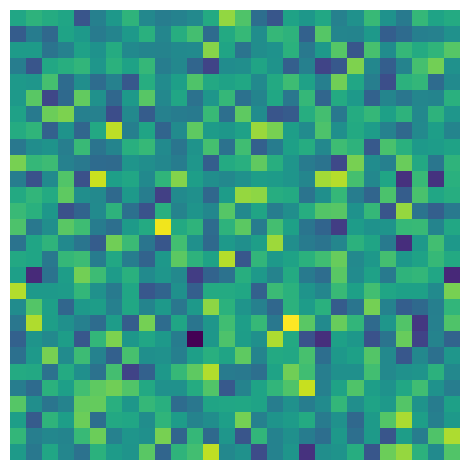

Finished training with lambda = 0
Training with lambda = 0.001
epoch: 0 current loss: 12.598843574523926
epoch: 1000 current loss: 0.001069212332367897
epoch: 2000 current loss: 0.00031454383861273527
epoch: 3000 current loss: 0.0001399419124936685
epoch: 4000 current loss: 7.152301259338856e-05
epoch: 5000 current loss: 4.005352093372494e-05
epoch: 6000 current loss: 2.3245540432981215e-05
epoch: 7000 current loss: 1.3708974620385561e-05
epoch: 8000 current loss: 8.106198947643861e-06
epoch: 9000 current loss: 4.887569048150908e-06
epoch: 10000 current loss: 2.9802276912960224e-06
epoch: 11000 current loss: 1.7881377516459906e-06
epoch: 12000 current loss: 1.0728830375228426e-06
epoch: 13000 current loss: 5.960462772236497e-07
epoch: 14000 current loss: 3.576278118089249e-07
epoch: 15000 current loss: 2.3841855067985307e-07
epoch: 16000 current loss: 1.1920928244535389e-07
epoch: 17000 current loss: 1.1920928244535389e-07
epoch: 18000 current loss: 0.0
epoch: 19000 current loss: 0.0
e

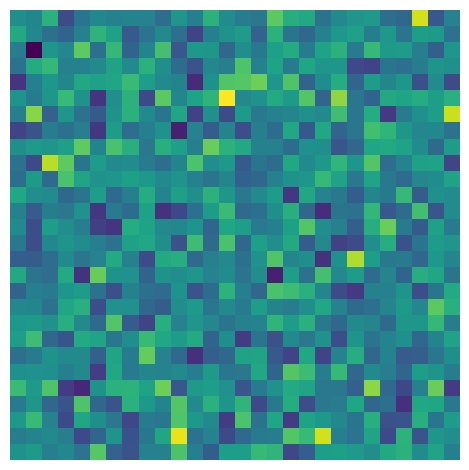

Finished training with lambda = 0.001
Training with lambda = 0.01
epoch: 0 current loss: 12.51209831237793
epoch: 1000 current loss: 0.0005859803641214967
epoch: 2000 current loss: 0.00017069313616957515
epoch: 3000 current loss: 7.557583012385294e-05
epoch: 4000 current loss: 3.909988299710676e-05
epoch: 5000 current loss: 2.1457441107486375e-05
epoch: 6000 current loss: 1.2159273865108844e-05
epoch: 7000 current loss: 7.152531907195225e-06
epoch: 8000 current loss: 4.410734163684538e-06
epoch: 9000 current loss: 2.622600959512056e-06
epoch: 10000 current loss: 1.5497195136049413e-06
epoch: 11000 current loss: 9.536738616588991e-07
epoch: 12000 current loss: 5.960462772236497e-07
epoch: 13000 current loss: 2.3841855067985307e-07
epoch: 14000 current loss: 2.3841855067985307e-07
epoch: 15000 current loss: 1.1920928244535389e-07
epoch: 16000 current loss: 1.1920928244535389e-07
epoch: 17000 current loss: 0.0
epoch: 18000 current loss: 0.0
epoch: 19000 current loss: 0.0
epoch: 20000 curr

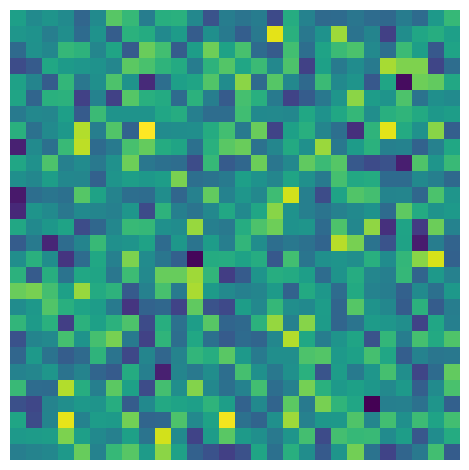

Finished training with lambda = 0.01
Training with lambda = 0.1
epoch: 0 current loss: 5.9900336265563965
epoch: 1000 current loss: 0.0008833082392811775
epoch: 2000 current loss: 0.000259365770034492
epoch: 3000 current loss: 0.00011359999916749075
epoch: 4000 current loss: 5.793403761344962e-05
epoch: 5000 current loss: 3.0517112463712692e-05
epoch: 6000 current loss: 1.6927575416048057e-05
epoch: 7000 current loss: 9.536697689327411e-06
epoch: 8000 current loss: 5.602820692729438e-06
epoch: 9000 current loss: 3.3378546504536644e-06
epoch: 10000 current loss: 2.0265558760002023e-06
epoch: 11000 current loss: 1.1920922133867862e-06
epoch: 12000 current loss: 7.152555099310121e-07
epoch: 13000 current loss: 4.768370445162873e-07
epoch: 14000 current loss: 3.576278118089249e-07
epoch: 15000 current loss: 1.1920928244535389e-07
epoch: 16000 current loss: 1.1920928244535389e-07
epoch: 17000 current loss: 0.0
epoch: 18000 current loss: 0.0
epoch: 19000 current loss: 0.0
epoch: 20000 curren

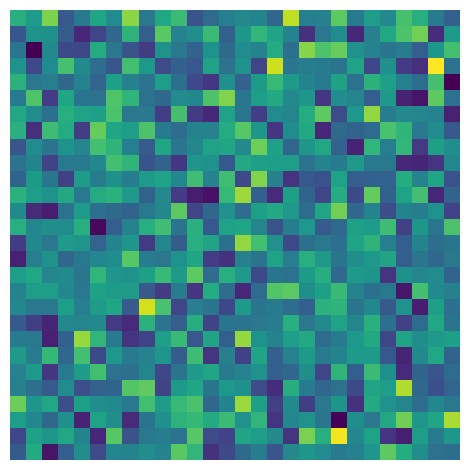

Finished training with lambda = 0.1
Training with lambda = 1.0
epoch: 0 current loss: 18.308330535888672
epoch: 1000 current loss: 0.0014240134041756392
epoch: 2000 current loss: 0.0004182179400231689
epoch: 3000 current loss: 0.0001867835089797154
epoch: 4000 current loss: 9.643566590966657e-05
epoch: 5000 current loss: 5.352353764465079e-05
epoch: 6000 current loss: 3.0874729418428615e-05
epoch: 7000 current loss: 1.8000440832111053e-05
epoch: 8000 current loss: 1.07287787614041e-05
epoch: 9000 current loss: 6.318072337307967e-06
epoch: 10000 current loss: 3.814689989667386e-06
epoch: 11000 current loss: 2.264974000354414e-06
epoch: 12000 current loss: 1.4305104514278355e-06
epoch: 13000 current loss: 8.344646857949556e-07
epoch: 14000 current loss: 4.768370445162873e-07
epoch: 15000 current loss: 3.576278118089249e-07
epoch: 16000 current loss: 2.3841855067985307e-07
epoch: 17000 current loss: 1.1920928244535389e-07
epoch: 18000 current loss: 1.1920928244535389e-07
epoch: 19000 curr

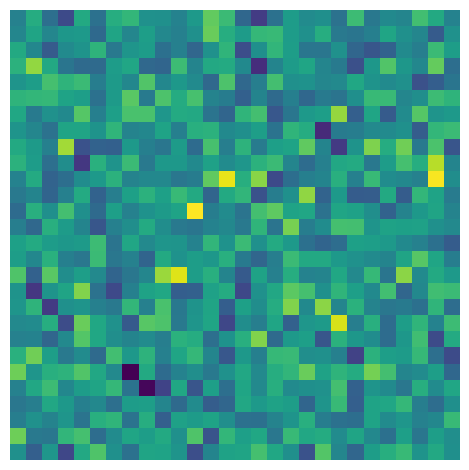

Finished training with lambda = 1.0
Training with lambda = 10.0
epoch: 0 current loss: 24.83483123779297
epoch: 1000 current loss: 0.002172611653804779
epoch: 2000 current loss: 0.0005999195855110884
epoch: 3000 current loss: 0.0002631794777698815
epoch: 4000 current loss: 0.00013517419574782252
epoch: 5000 current loss: 7.509902934543788e-05
epoch: 6000 current loss: 4.2914423829643056e-05
epoch: 7000 current loss: 2.4676019165781327e-05
epoch: 8000 current loss: 1.4662635294371285e-05
epoch: 9000 current loss: 8.821448318485636e-06
epoch: 10000 current loss: 5.364403477869928e-06
epoch: 11000 current loss: 3.2186455882765586e-06
epoch: 12000 current loss: 1.9073468138230965e-06
epoch: 13000 current loss: 1.1920922133867862e-06
epoch: 14000 current loss: 7.152555099310121e-07
epoch: 15000 current loss: 4.768370445162873e-07
epoch: 16000 current loss: 2.3841855067985307e-07
epoch: 17000 current loss: 1.1920928244535389e-07
epoch: 18000 current loss: 0.0
epoch: 19000 current loss: 0.0
e

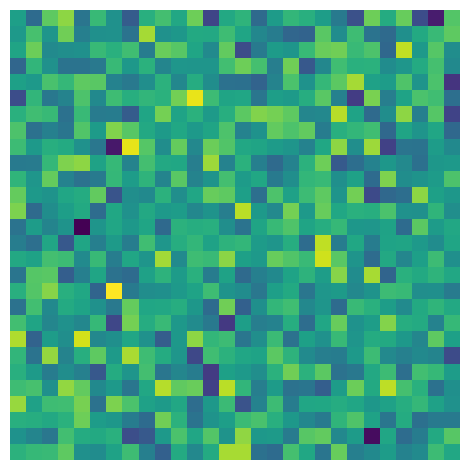

Finished training with lambda = 10.0


In [15]:
def train35(l, epochs):
    samples = torch.randn(1, 1, 28, 28, device=device, requires_grad=True)
    # Normalize samples.
    mean = torch.tensor(0.1307, device=device).reshape(1,1,1,1)
    std  = torch.tensor(0.3081, device=device).reshape(1,1,1,1)

    optimizer3 = torch.optim.Adam([samples], 0.001)
    net.eval()
    for epoch in range(epochs):
        optimizer3.zero_grad()
        normed = (samples - mean) / std
        logits = net(normed)
        loss3 = torch.nn.functional.cross_entropy(logits, torch.tensor([3], device=device), reduction="mean")
        + torch.nn.functional.cross_entropy(logits, torch.tensor([5], device=device), reduction="mean") + l * samples.pow(2).mean()
        if epoch % 1000 == 0:
            print("epoch:", epoch, "current loss:", loss3.item())
        loss3.backward()
        optimizer3.step()
    return samples


def plot_image(image):
  img = image.squeeze().cpu().detach()
  plt.imshow(img)
  plt.axis('off')
  plt.tight_layout()
  plt.show()

# Train and plot for different lambdas.
lambda_values = [0, 0.001, 0.01, 0.1, 1.0, 10.0]
for l in lambda_values:
    print(f"Training with lambda = {l}")
    image = train35(l, epochs)
    plot_image(image)
    print(f"Finished training with lambda = {l}")

Despite the convergence of the loss function, the generated images do not resemble any of the desired digits. In fact, they do not appear to resemble anything meaningful at all.